# Лабораторная работа №5
Постановка задачи:
1. Написать 3 генератора данных, из которых будет восстанавливаться плотность,
2. Написать реализацию метода Парзена-Розенблатта, где в качестве параметров указать различные ширины окна и типы ядра,
3. Восстановить плотность в виде изображения, основываясь на п.1 и п.2,
4. Реализовать для одного из трех генераторов применить оптимизацию ширины окна методом Leave One Out,
5. Применить EM-алгоритм из Scikit-learn.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

## Распределения

### Нормальное распределение

In [ ]:
def GaussNumbers(mu, sigma, n):
    points = np.random.default_rng().normal(mu, sigma, n)
    return points

In [ ]:
def GaussDistribution(x_val, mu, sigma):  
    formula = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x_val - mu)**2 / (2 * sigma**2))
    return formula

### Экспоненциальное распределение

In [ ]:
def ExponentNumbers(lamda, n):
    points = np.random.exponential(scale = 1 / lamda, size = n)
    return points

In [ ]:
def ExponentDistribution(x_val, lamda):  
    formula = lamda * np.exp(-lamda * x_val)
    return formula

### Равномерное распределение

In [ ]:
def UniformNumbers(a, b, n):
    points = np.random.uniform(a, b, n)
    return points

In [ ]:
def UniformDistribution(times, a, b):  
    formula = [1 / (b - a)] * len(times)
    return formula

## Реализуемые методы

### Визуализация распределения

In [ ]:
def DrawDistribution(dist_points, dist_formula, n, *args):
    count, bins, ignored = plt.hist(dist_points, bins = 30, density = True)
    plt.plot(bins, dist_formula(bins, *args), linewidth = 2, color = 'r')
    plt.show()

### Гауссовское ядро

In [ ]:
def GaussKernel(r):
    kernel_gauss = ((2 * np.pi) ** (- 1 / 2)) * np.exp(- (1 / 2) * (r ** 2))
    return kernel_gauss

### Оптимальное (Епанечникова) ядро

In [ ]:
def EpnKernel(r):
    kernel_Epn = (3 / 4) * (1 - r ** 2)
    return kernel_Epn

### Квартическое ядро

In [ ]:
def QuarKernel(r):
    kernel_quar = (15 / 16) * ((1 - (r ** 2)) ** 2)
    return kernel_quar

### Метод окна Парзена-Розенблатта
**Ядерная оценка плотности (ЯОП**, англ. *Kernel Density Estimation*, **KDE)** — это непараметрический способ оценки плотности случайной величины. Ядерная оценка плотности является задачей сглаживания данных, когда делается заключение о совокупности, основываясь на конечных выборках данных. В некоторых областях, таких как обработка сигналов и математическая экономика, метод называется также методом **окна Парзена-Розенблатта**.

In [ ]:
def KDE(points, kernel_val, n, name, arr):
    #points = dist_points(arg1, arg2, n)
    step = abs((min(points) - max(points))/n)
    for h in arr:
        p_x_list = []
        for x in np.arange(min(points), max(points), step):
            #----Parz
            kernel_list = []
            for i in range(0, n):
                r = (x - points[i]) / h
                #kernel_val = ((2 * np.pi) ** (- 1 / 2)) * np.exp(- (1 / 2) * (r ** 2))
                if name == 'GaussKernel':
                    kernel_list.append(kernel_val(r))
                elif abs(r) <= 1:
                    kernel_list.append(kernel_val(r))
            
            p_x = (1 / (n * h)) * sum(kernel_list)
            #-----
            p_x_list.append(p_x)

        #x_points = np.arange(min(points), max(points), 1 / n)
        #x_points = np.arange(min(points), max(points), abs((min(points) - max(points))/(n+1)))
        x_points = np.arange(min(points), max(points), step)
        plt.plot(x_points, p_x_list, label = 'h = {0}'.format(h))
        plt.legend()

        plt.title("Kernel Density Estimation")
        plt.xlabel("x")
        plt.ylabel("Density")
    plt.scatter(points, np.zeros(n), marker = '|', color = 'r')
    plt.show()

### Leave One Out (LOO)
Выбор ширины окна с помощью скользящего контроля *Leave One Out* для оценки плотности.

In [ ]:
def LOO(points, kernel_val, n, name):
    
    step = abs((min(points) - max(points))/n)
    loo_list = []
    h_points = np.arange(0.09, 0.25, 0.01)
    for h in h_points:
    #for h in np.arange(0.005, 0.5, 0.05):
        p_x_list = []
        num = 0
        for x in np.arange(min(points), max(points), step):
            #----Parz
            kernel_list = []
            
            for i in range(0, n):
                if i != num:
                    r = (x - points[i]) / h
                else:
                    continue
                #kernel_val = ((2 * np.pi) ** (- 1 / 2)) * np.exp(- (1 / 2) * (r ** 2))
                if name == 'GaussKernel':
                    kernel_list.append(kernel_val(r))
                elif abs(r) <= 1:
                    kernel_list.append(kernel_val(r))
            
            p_x = (1 / (n * h)) * sum(kernel_list)
            #-----
            p_x_list.append(-np.log(p_x))
            num += 1

        loo_list.append(sum(p_x_list))

    loo_min = min(loo_list)
    idx = loo_list.index(loo_min)
    h_opt = h_points[idx]
    print(loo_min, h_opt)
    #h_points = np.arange(0.001, 1, 0.1)
    plt.plot(h_points, loo_list)
    plt.legend()

    plt.title("Leave One Out")
    plt.xlabel("h")
    plt.ylabel("LOO")
    plt.show()
    return h_opt

### EM-алгоритм
**EM-алгоритм** (англ. *Expectation-maximization (EM) algorithm*) — алгоритм, используемый в математической статистике для нахождения оценок максимального правдоподобия параметров вероятностных моделей, в случае, когда модель зависит от некоторых скрытых переменных. Каждая итерация алгоритма состоит из двух шагов. 

На **E-шаге** *(expectation)* вычисляется ожидаемое значение функции правдоподобия, при этом скрытые переменные рассматриваются как наблюдаемые. 

На **M-шаге** *(maximization)* вычисляется оценка максимального правдоподобия, таким образом увеличивается ожидаемое правдоподобие, вычисляемое на E-шаге. Затем это значение используется для E-шага на следующей итерации. 

Алгоритм выполняется до сходимости. Часто EM-алгоритм используют для разделения смеси гауссиан.

**Scikit-learn** реализует EM-алгоритм с помощью функции **GaussianMixture**.

In [ ]:
def em_algo(points, n):
    step = abs((min(points) - max(points))/n)
    x_points = np.arange(min(points), max(points), step).reshape(-1, 1)

    #X = arr.reshape(-1, 1)
    gm = GaussianMixture(n_components = 2, random_state = 0).fit(x_points)
    y = gm.predict_proba(np.array(x_points).reshape(-1, 1))
    plt.plot(x_points, y[:, 0], x_points, y[:, 1])
    plt.show()
    print(gm.means_)

## Нормальное распределение

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
<br>
$$
f(x) = \frac{1} { \sigma \sqrt {2\pi} } e^{\frac{-(x - \mu)^2} {2 \sigma ^2}}
$$
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;

In [ ]:
mu = 0
sigma = 0.1
n = 1000

h_nums = [0.015, 0.005, 0.1]

gauss_nums = GaussNumbers(mu, sigma, n)
print(gauss_nums[:10])

[ 0.10083002 -0.14772321  0.11281381 -0.06461915 -0.11397802  0.08464116
  0.07934926  0.10501049  0.10869494 -0.12534817]


### Визуализация нормального распределения

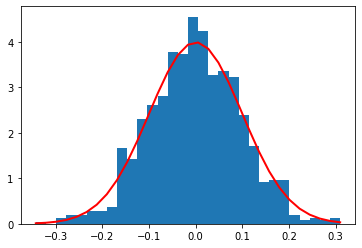

In [ ]:
DrawDistribution(gauss_nums, GaussDistribution, n, mu, sigma)

### Зависимость оценки плотности при различных значениях ширины окна *h*


#### Гауссовское ядро

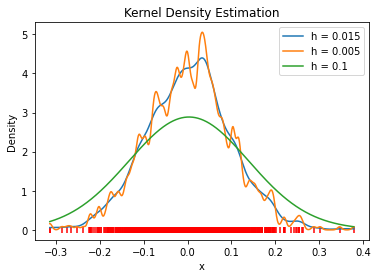

In [ ]:
KDE(gauss_nums, GaussKernel, n, 'GaussKernel', h_nums)

#### Ядро Епанечникова

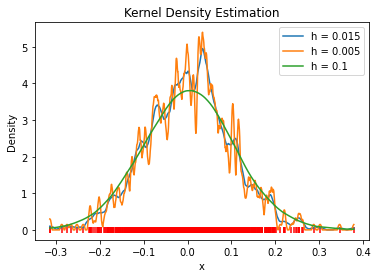

In [ ]:
KDE(gauss_nums, EpnKernel, n, 'EpnKernel', h_nums)

#### Квартическое ядро

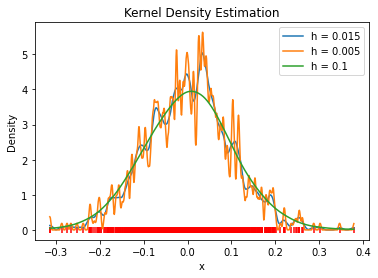

In [ ]:
KDE(gauss_nums, QuarKernel, n, 'QuarKernel', h_nums)

### Выбор ширины окна с помощью метода Leave One Out

-176.37816317004092 0.17999999999999994


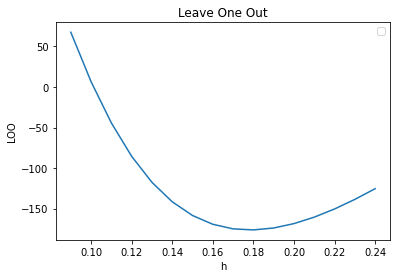

In [ ]:
h_opt = LOO(gauss_nums, GaussKernel, n - 1, 'GaussKernel')

### Оценка плотности при оптимальной ширине окна
#### Гауссовское ядро

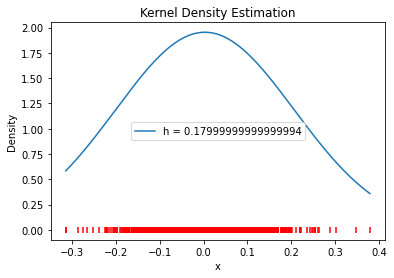

In [ ]:
KDE(gauss_nums, GaussKernel, n, 'GaussKernel', [h_opt])

### EM-алгоритм из Scikit-learn

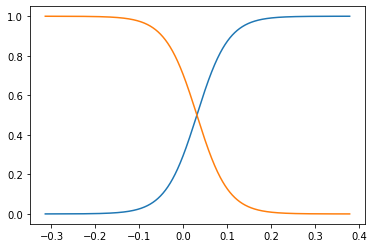

[[ 0.19940552]
 [-0.13576497]]


In [ ]:
em_algo(gauss_nums, n)

## Экспоненциальное распределение

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
<br>
$$
f(x) = λ e^{-λx}
$$
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;

In [ ]:
lamda = 4
exp_nums = ExponentNumbers(lamda, n)
print(exp_nums[:10])

[0.19539848 0.43335863 0.55244254 0.24157559 0.09337586 0.18321653
 0.08783939 0.32207165 0.14077758 0.10247365]


### Визуализация экспоненциального распределения

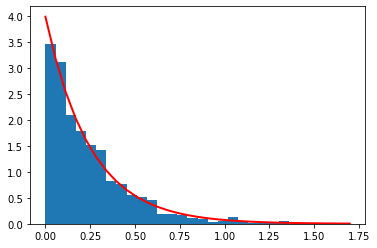

In [ ]:
DrawDistribution(exp_nums, ExponentDistribution, n, lamda)

### Зависимость оценки плотности при различных значениях ширины окна *h*


#### Гауссовское ядро

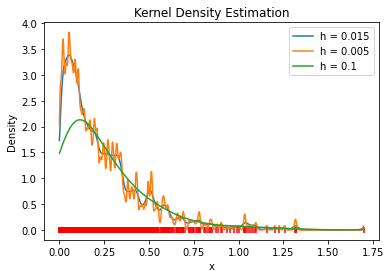

In [ ]:
KDE(exp_nums, GaussKernel, n, 'GaussKernel', h_nums)

#### Ядро Епанечникова

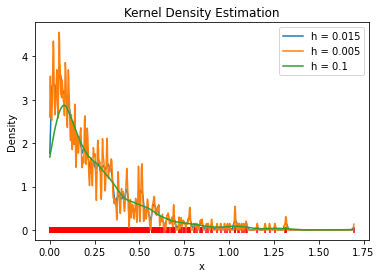

In [ ]:
KDE(exp_nums, EpnKernel, n, 'EpnKernel', h_nums)

#### Квартическое ядро

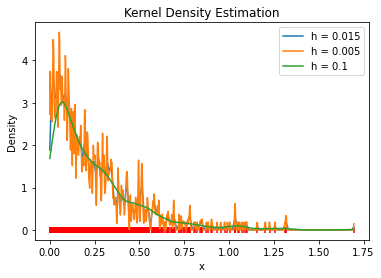

In [ ]:
KDE(exp_nums, QuarKernel, n, 'QuarKernel', h_nums)

### Выбор ширины окна с помощью метода Leave One Out

1850.5575002880505 0.2399999999999999


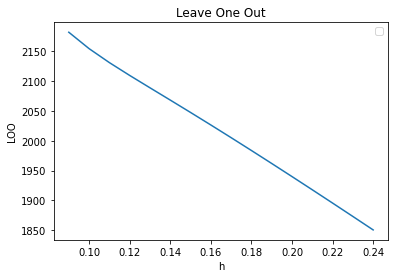

In [ ]:
h_opt = LOO(exp_nums, GaussKernel, n - 1, 'GaussKernel')

### Оценка плотности при оптимальной ширине окна
#### Гауссовское ядро

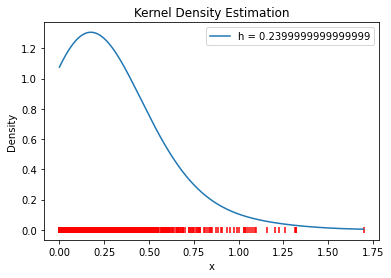

In [ ]:
KDE(exp_nums, GaussKernel, n, 'GaussKernel', [h_opt])

### EM-алгоритм из Scikit-learn

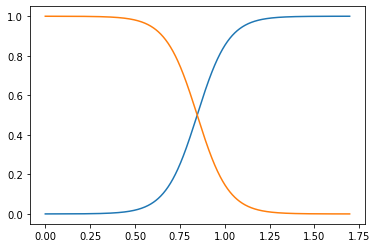

[[1.25739405]
 [0.43749817]]


In [ ]:
em_algo(exp_nums, n)

## Равномерное распределение

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
<br>
$$
f(x) = \frac{1} { b - a }
$$
<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;

In [ ]:
a = 0
b = 10
unif_nums = UniformNumbers(a, b, n)
print(unif_nums[:10])

[3.26857233 2.91212944 6.97753068 3.15083689 2.19767941 2.63430823
 1.34990984 7.3617808  2.84251036 6.83976396]


### Визуализация раномерного распределения

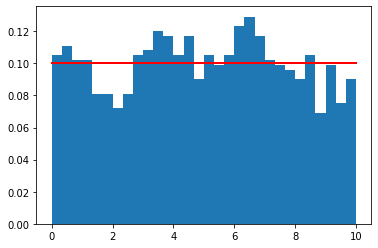

In [ ]:
DrawDistribution(unif_nums, UniformDistribution, n, a, b)

#### Гауссовское ядро

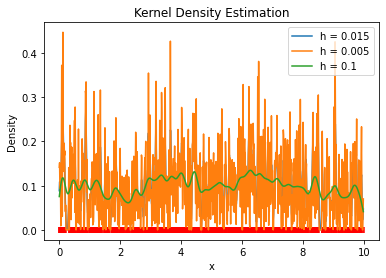

In [ ]:
KDE(unif_nums, GaussKernel, n, 'GaussKernel', h_nums)

#### Ядро Епанечникова

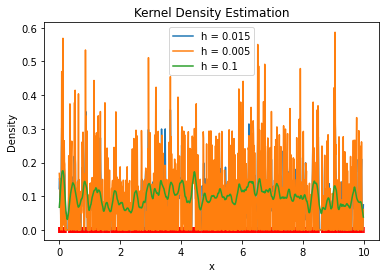

In [ ]:
KDE(unif_nums, EpnKernel, n, 'EpnKernel', h_nums)

#### Квартическое ядро

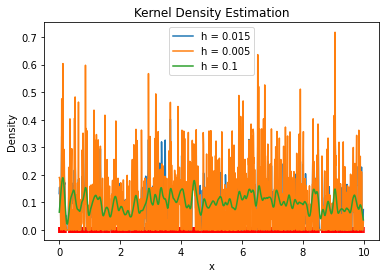

In [ ]:
KDE(unif_nums, QuarKernel, n, 'QuarKernel', h_nums)

### Выбор ширины окна с помощью метода Leave One Out

2325.4615495959574 0.10999999999999999


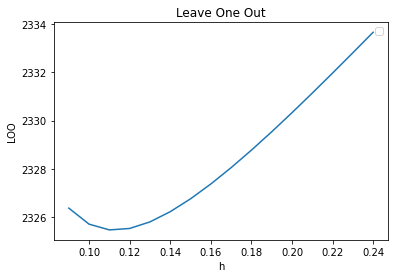

In [ ]:
h_opt = LOO(unif_nums, GaussKernel, n - 1, 'GaussKernel')

### Оценка плотности при оптимальной ширине окна
#### Гауссовское ядро

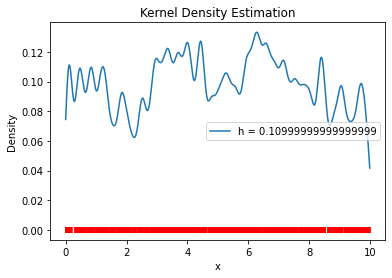

In [ ]:
KDE(unif_nums, GaussKernel, n, 'GaussKernel', [h_opt])

### EM-алгоритм из Scikit-learn

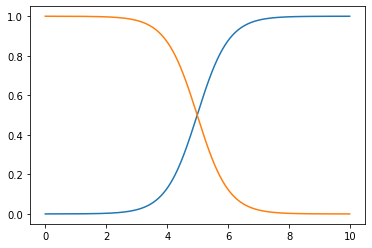

[[7.40088201]
 [2.57489714]]


In [ ]:
em_algo(unif_nums, n)